# Machine Learning Fellowship Challenge
## Predicting Global Terrorism Groups - An Application Submission

### Overview and Objective

This is a submission as part of Angus Ning's application to the Machine Learning Fellowship. Models and analyses are conducted on the public Global Terrorism Database.

The database contains information about over 170,000 terrorist attacks that were recorded since 1971, including features such as date/time, location, attack type, responsible group (if identified), target type, weapon type, and fatalities/injuries.

Around 78,000 of the entries have no responsible group identified. This project will seek to build a model to predict an attack's responsible group based on feature data.

As reference, this data was recently explored by a group of members of Rostlab (www.rostlab.org) at the Technical University of Munich. They achieved a test accuracy of > 70% on test points from seven of the geographic regions (https://github.com/Rostlab/DM_CS_WS_2016-17/wiki/Week-10-%28W05-Feb01%29-Terrorism-Database).

An HTML copy of this project is available on Github, which displays the results of this project without needing to re-run the Python scripts, the entirety of which is known to take ~6-7 hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
import os

try:
    t_file = pd.read_csv('input/gtd_data.csv', encoding='ISO-8859-1',
                         usecols=[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 28, 29, 34, 35, 58, 81, 82, 98, 101])
    print('File load: Success')
except:
    print('File load: Failed')

File load: Success


### Data Exploration
#### Geographic Distribution

We begin by examining the distribution of terrorist attacks across geographic areas. We observe from the results that some regions see a much higher rate of terrorist attacks (such as Middle East & North Africa, South Asia, and Sub-Saharan Africa), than others (such as Central Asia, East Asia, and Australasia & Oceania).

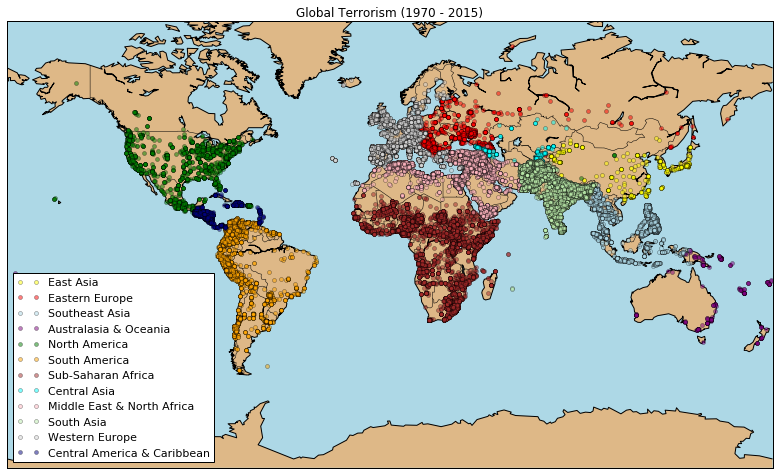

In [2]:
terror_data = t_file.rename(
    columns={'eventid':'id', 'iyear':'year', 'imonth':'month', 'iday':'day',
             'country':'country_id','country_txt':'country', 'region':'region_id','region_txt':'region',
             'provstate':'state', 'attacktype1':'attackcat', 'attacktype1_txt':'attacktype1', 'targtype1':'targtype',
             'targtype1_txt':'target', 'gname':'group', 'weaptype1':'weaptype1','weaptype1_txt':'weapon',
             'nkill':'fatalities', 'nwound':'injuries'})
del t_file

regions = list(set(terror_data.region))
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange', 'brown',\
          'aqua', 'lightpink', 'lightsage', 'lightgray', 'navy']

plt.figure(figsize=(15,8))
m1 = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

def makeworld(m):
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='burlywood',lake_color='lightblue', zorder = 1)
    m.drawmapboundary(fill_color='lightblue')

makeworld(m1)

def pltpoints(region, m, color = None, label = None,):
    x, y = m(list(terror_data.longitude[terror_data.region == region].astype("float")),\
            (list(terror_data.latitude[terror_data.region == region].astype("float"))))
    points = m.plot(x, y, "o", markersize = 4, color = color, label = label, alpha = .5)
    return(points)

for i, region in enumerate(regions):
    pltpoints(region, m1, color = colors[i], label = region)  
    
plt.title("Global Terrorism (1970 - 2015)")
plt.legend(loc ='lower left', prop= {'size':11})
plt.show() 

#### Geographic Distribution by Terrorist Group

We then consider the 12 terrorist groups with the most attacks attributed to them, and see how their attacks are geographically distributed. It becomes obvious that each terrorist group's attacks are highly geographically motivated - we see clear clusters form for each group. This means that when predicting responsible groups for unattributed attacks, geographic region and exact location will be strongly deterministic towards the result.

Conversely, it also means that for the sake of efficiency, for a given test sample, we can train its prediction model using only training points from the same geographic region, without significant loss of accuracy.

Moreover, we note that many groups act within specified national borders. For example, ETA operates overwhelmingly in Spain, FARC in Colombia, and ISIL in Iraq. This means that our prediction model should more heavily weight country features.

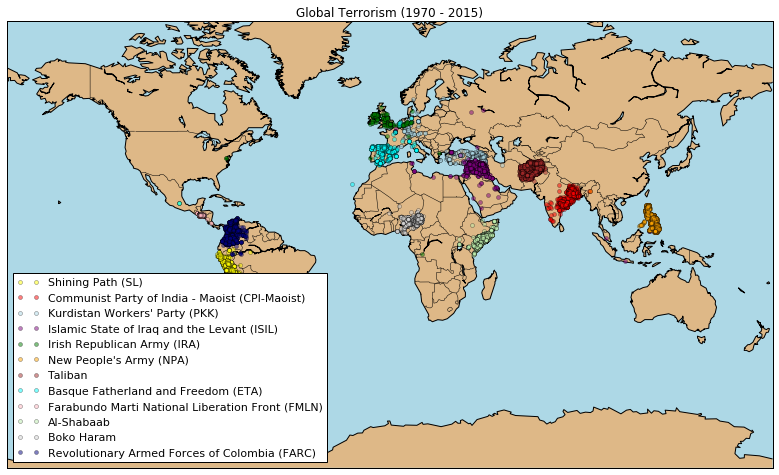

In [3]:
top_groups = terror_data.groupby(['group'])['id'].count().nlargest(13).keys()

# Drop the most common "group" as it is "Unknown"
top_groups = top_groups.delete(0)
top_groups = list(set(top_groups))

plt.figure(figsize=(15,8))
m2 = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

makeworld(m2)

def pltpoints(tgroup, m, data, color = None, label = None):
    x, y = m(list(data.longitude[data.group == tgroup].astype("float")),\
            (list(data.latitude[data.group == tgroup].astype("float"))))
    points = m.plot(x, y, "o", markersize = 4, color = color, label = label, alpha = .5)
    return(points)

for i, tgroup in enumerate(top_groups):
    pltpoints(tgroup, m2, terror_data, color = colors[i], label = tgroup)  
    
plt.title("Global Terrorism (1970 - 2015)")
plt.legend(loc ='lower left', prop= {'size':11})
plt.show()

#### Group Activity Over Time

Next, we consider the activity level of the 12 most active groups over the course of time. We hypothesize that some groups may have been active in earlier decades may not be so now, and vice versa.

Looking at the visualization, the Irish Republican Army was highly active from 1970 to the mid-90s. In comparison, ISIL only showed activity in the 2010s. This means that the year of attack will be another strongly deterministic feature we can rely on in predicting groups behind unattributed attacks. We can see this more clearly in the second plot, where plot heights are normalized to 100%.

As a side note, we observe that the collective activity level of the 12 most active groups has sharply risen this decade. It previously had a peak of activity in the 1980s-early 90s.

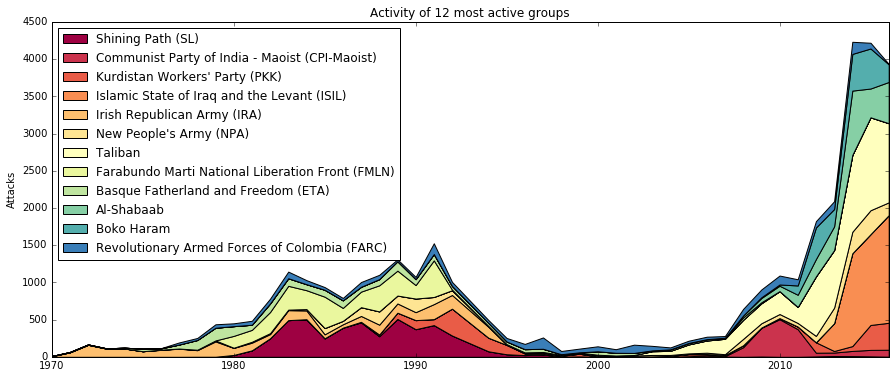

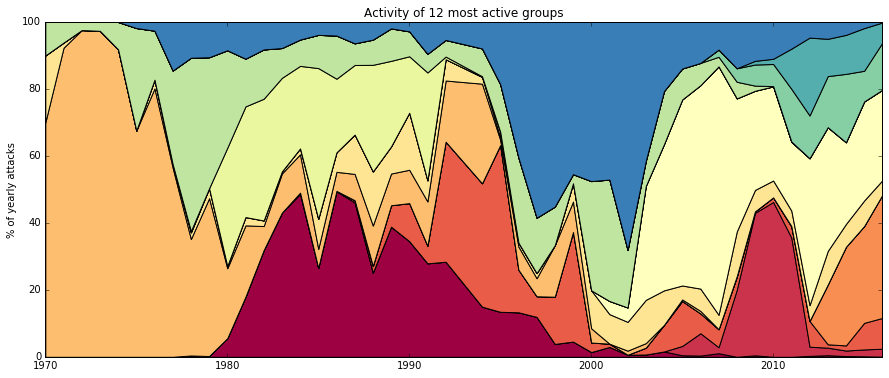

In [4]:
def datastack(top_groups, data):
    x = data['year'].unique()
    x.sort()
    y = {}
    for g in top_groups:
        y[g] = [0]*len(x)
        for i in range(len(x)):
            y[g][i] = data[data['year']==x[i]][data['group']==g].count()['id']

    ystack = np.row_stack(y.values())
    ykeys = y.keys()
    
    NUM_COLORS = len(ykeys)

    cm = plt.get_cmap('Spectral')
    return x, ystack, ykeys, cm, NUM_COLORS

x, ystack, ykeys,cm,NUM_COLORS = datastack(top_groups, terror_data)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

def plotstack(x, ystack, ykeys, cm, ax, NUM_COLORS, title):
    ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    ax.stackplot(x,ystack)
    ax.margins(0,0)
    ax.set_ylim([0,4500])
    ax.set_title(title)
    ax.set_ylabel('Attacks')
    plt.legend(ykeys,loc=2)
    plt.show()

plotstack(x, ystack, ykeys, cm, ax, NUM_COLORS, 'Activity of 12 most active groups')

fig2 = plt.figure(figsize=(15,6))
ax2 = fig2.add_subplot(111)

def plotnormstack(x, ystack, ykeys, cm, ax, NUM_COLORS, title):
    # Normalize columns into percentages instead of number of attacks
    percent = ystack /  ystack.sum(axis=0).astype(float) * 100 
    ax2.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    ax2.stackplot(x,percent)
    ax2.margins(0,0)
    ax2.set_ylim([0,100])
    ax2.set_title(title)
    ax2.set_ylabel('% of yearly attacks')
    plt.show()

plotnormstack(x, ystack, ykeys, cm, ax2, NUM_COLORS, 'Activity of 12 most active groups')

#### Modus Operandi

It is possible that a terrorist group will have a preferred modus operandi, specifically in the area of attack type, primary weapon, or target.

To begin, we look at each of the 12 most active terrorist groups, and plot the number of attacks they're responsible for given attack and weapon type. We notice some clusters form for certain groups. For example:

-  ISIL has a strong preference for attack type 3 (Bombing/Explosion) and weapon type 6 (Explosives) - an unsurprising correlation between the two
-  IRA aside from sharing ISIL's preference for the (3,4) pairing for (attack, weapon), also has a history of executing attack type 1 (Assassination) via weapon 5 (Firearms)

While many groups do exhibit clustered behaviors along these two dimensions, they appear to share a lot of the same clusters, preferring attacks of the type {2,3,4}, and weapons of the type {5,6}. Using these two features alone will make it hard to distinguish between groups.

Next, we can look at the number of attacks each group is responsible for given attack and target type. Again, some clusters form. For example: 

-  Taliban heavily leans towards target types {2,3,4}, which correspond to government, police, and military
-  Meanwhile, Shining Path leans towards target types {2,3,4}, but also types {14,21}, which correspond to private citizens & property, and utilities

This suggests that we may be able to combine attack, weapon, and target types to help further distinguish between terrorist groups.

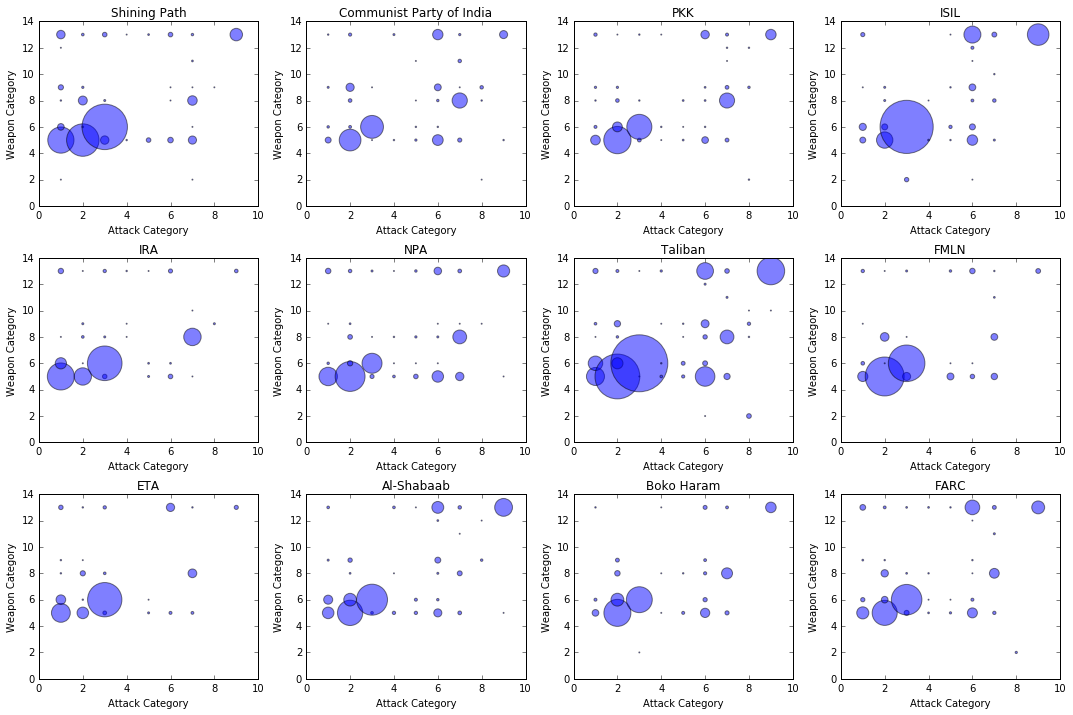

In [5]:
# Manually set shorthand names for active terrorist groups. Shortened names are still sufficient
# as a substring that uniquely matches the corresponding group's full name
group_categories = ['Shining Path', 'Communist Party of India', 'PKK', 'ISIL',
                     'IRA', 'NPA', 'Taliban', 'FMLN', 'ETA', 'Al-Shabaab', 'Boko Haram', 'FARC']

fig = plt.figure(figsize=[15,10])

i = 0

for g in group_categories:
    attacks = terror_data[terror_data['group'].str.contains(g)]
    attackweapcat = attacks[['id','attackcat','weaptype1']]
    attackweap_count = np.asarray(attackweapcat.groupby(['attackcat','weaptype1']).id.count())
    attackweap_percent = np.round(attackweap_count / sum(attackweap_count) * 100, 2)
    attackcat_count = np.asarray(attackweapcat.groupby(['attackcat','weaptype1'])['attackcat'].mean())
    weapcat_count = np.asarray(attackweapcat.groupby(['attackcat','weaptype1'])['weaptype1'].mean())
    ax = fig.add_subplot(3,4,i+1)
    ax.set_title(g)
    ax.set_xlabel('Attack Category')
    ax.set_ylabel('Weapon Category')
    ax.set_xlim([0,10])
    ax.set_ylim([0,14])
    plt.scatter(attackcat_count,weapcat_count,s=attackweap_count,alpha=0.5)
    i += 1
plt.tight_layout()
plt.show()

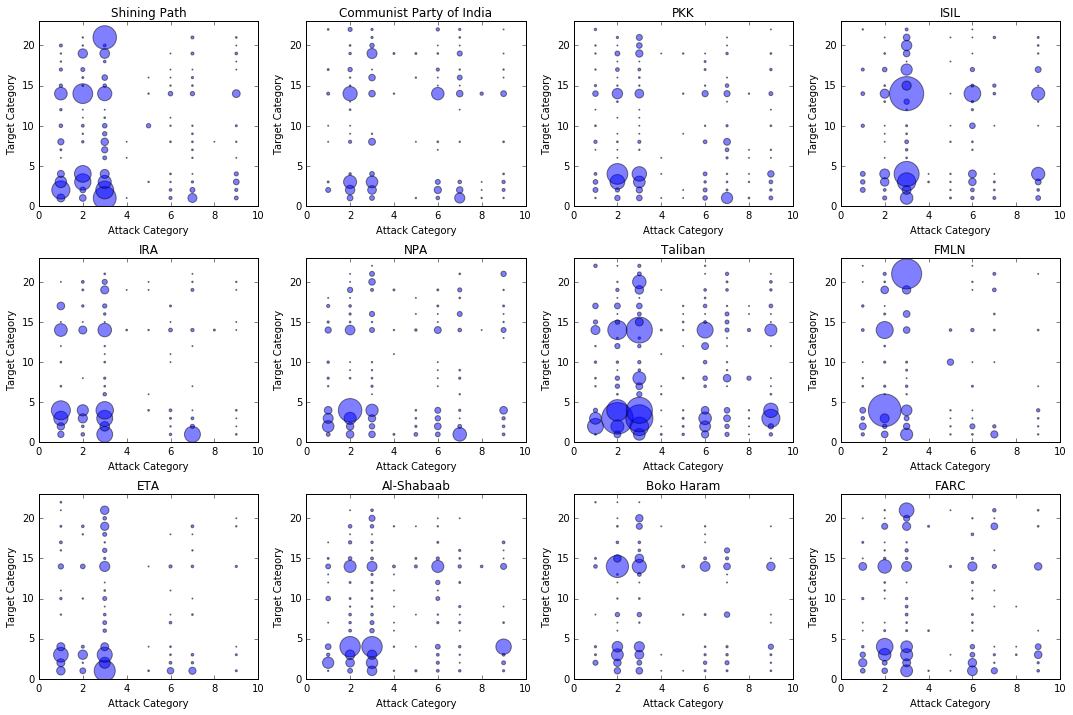

In [6]:
fig = plt.figure(figsize=[15,10])

i = 0

for g in group_categories:
    attacks = terror_data[terror_data['group'].str.contains(g)]
    attacktargcat = attacks[['id','attackcat','targtype']]
    attacktarg_count = np.asarray(attacktargcat.groupby(['attackcat','targtype']).id.count())
    attacktarg_percent = np.round(attacktarg_count / sum(attacktarg_count) * 100, 2)
    attackcat_count = np.asarray(attacktargcat.groupby(['attackcat','targtype'])['attackcat'].mean())
    targcat_count = np.asarray(attacktargcat.groupby(['attackcat','targtype'])['targtype'].mean())
    ax = fig.add_subplot(3,4,i+1)
    ax.set_title(g)
    ax.set_xlabel('Attack Category')
    ax.set_ylabel('Target Category')
    ax.set_xlim([0,10])
    ax.set_ylim([0,23])
    plt.scatter(attackcat_count,targcat_count,s=attacktarg_count,alpha=0.5)
    i += 1
plt.tight_layout()
plt.show()

#### Fatalities and Injuries
Finally we can consider the fatalities and injuries patterns for these groups. Unsurprisingly, all groups' plots look like a quarter disc cluster centered at the origin. However, the radius of this cluster varies across groups. ISIL and Taliban have more incidents of more fatalities and/or injuries, while NPA and ETA's attacks tend to have fewer than 20 injuries and fatalities, respectively.

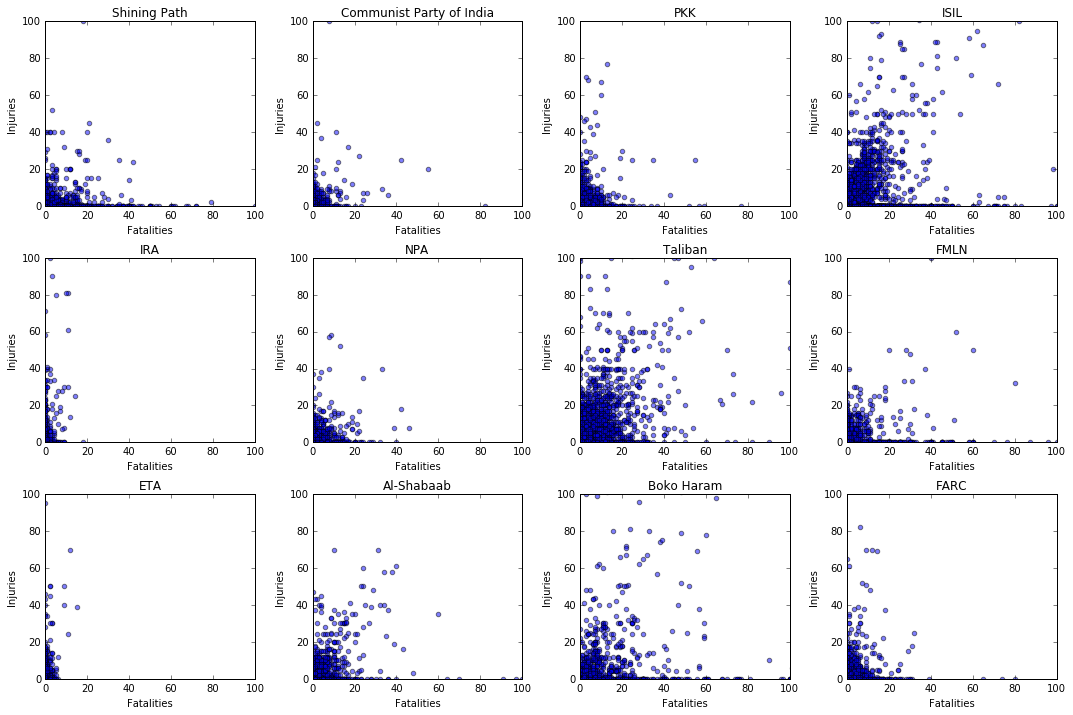

In [7]:
# For attacks where fatalities or injuries are NaN, we assign a default value of 0
terror_data['fatalities'] = terror_data['fatalities'].fillna(0).astype(int)
terror_data['injuries'] = terror_data['injuries'].fillna(0).astype(int)

fig = plt.figure(figsize=[15,10])

i = 0

for g in group_categories:
    attacks = terror_data[terror_data['group'].str.contains(g)]
    victims = attacks[['id','fatalities','injuries']]
    fatalities = np.asarray(victims['fatalities'])
    injuries = np.asarray(victims['injuries'])
    ax = fig.add_subplot(3,4,i+1)
    ax.set_title(g)
    ax.set_xlabel('Fatalities')
    ax.set_ylabel('Injuries')
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    plt.scatter(fatalities,injuries,alpha=0.5)
    i += 1
plt.tight_layout()
plt.show()

#### Exploration Summary

In the data exploration, we began by visualizing the terrorist attacks grouped into geographic regions. This indicated a strong imbalance in that some regions saw much fewer attacks, while others saw much more.

In particular, we've noticed that terrorist groups's attacks are highly defined by their geographic region and timing (by year). We've also noticed that groups can have preferred types of attack, weapons, and target. However, these preferences seem to be quite common across different groups.

Looking ahead, we can expect to primarily rely on (read: heavily weigh) an unattributed attack's geographic and time features to predict the group responsible, while using attack, weapon, and target type to fine-tune the mode.

### Data Modeling

#### Feature Engineering
In order to train learning models, we will need to turn our categorical data into dummy variables. Recall from the data exploration that we noticed terrorist groups are highly defined by the geographic region in which they operate. For this reason, we will not introduce dummy variables to represent 'region'. Rather, in the training and testing stage, we will run separate train/tests for each of the geographic regions.

The columns to introduce dummy variables for are: country, attacktype1, target, weapon. We will also remove their categorical equivalents (pulled from the dataset) from the table.

While month and day were not explored in the data exploration, we will remove them from consideration as features too, as they intuitively would seem uncorrelated or marginally correlated with group identities.

We also try manually setting some feature weights based on conclusions drawn during the data exploration. In practice not all classifier models will actually be affected by this.

#### Train/Test Split
We now begin the construction of our prediction model. The first step is to take the set of attributed terrorist groups (group != 'Unknown'), bucket them by region, and then randomly split each bucket into training data (75%) and testing data (25%)

We also note that while many of the features, such as country and region, have corresponding categorical representations in the database, the prediction label (group) does not. So we create a mapping to represent terrorist groups with integer values.

In [8]:
from sklearn.model_selection import train_test_split

# Retain only labeled data to split into train/test sets
labeled = terror_data[terror_data['group'] != 'Unknown']
regions = labeled['region'].unique()

def bucket_data(labeled, test_portion):
    # Prepare to bucket data by 'region' before moving ahead
    labeled_buckets = {}
    X_all_buckets = {}
    y_all_buckets = {}
    
    # Create a master dictionary that maps terrorist group to its corresponding numerical label
    groupmap = {}
    i = 0
    
    # Remove categorical data columns from features set. Later on, we will use the string representation
    # of these features to generate dummy variables
    # Also remove state/city with the assumption that state would be too granular a feature/groups characterize their
    # attacks on the national level
    text_columns = ['month','day','country_id', 'region_id', 'state', 'city', 'attackcat', 'targtype', 'weaptype1']

    # Dummy variables to be created
    categoricals = ['country', 'attacktype1', 'target', 'weapon']

    for r in regions:
        data = labeled[labeled['region']==r].drop('region',1)
        labeled_buckets[r] = data
        X_all_b = data.drop('group',1)
        X_all_b = X_all_b.drop(text_columns,1)
        X_all_b = X_all_b.drop('id',1)
    
        for c in categoricals:
            col_data = pd.get_dummies(X_all_b[c], prefix=c)
            X_all_b = X_all_b.join(col_data)
            X_all_b = X_all_b.drop(c,1)
    
        X_all_buckets[r] = X_all_b

        y_all = data[['group']]
    
        groups = y_all['group'].unique()
        
        for item in groups:
            if(i>0 and item in groupmap):
                continue
            else:    
                i = i+1
                groupmap[item] = i

        y_all["group_id"] = y_all["group"].map(groupmap)
        y_all = y_all.drop('group',1)
    
        y_all_buckets[r] = y_all
    
    print "Selected features to model on:\n(Categorical features will be transformed into dummy variables)"

    print np.concatenate((X_all_b.columns.values[:5],np.asarray(categoricals)))

    X_train_buckets = {}
    X_test_buckets = {}
    y_train_buckets = {}
    y_test_buckets = {}
    sizes = pd.DataFrame()

    # Feature scaling - intention is to use these as feature weights. In practice not all models
    # will be affected by this
    fw = {'latitude':50,'longitude':50,'year':5,'fatalities':0.5,'injuries':0.5}

    for r in regions:
        num_train = int(np.round(X_all_buckets[r].shape[0]*(1-test_portion)))
        num_test = X_all_buckets[r].shape[0] - num_train
    
        X_all_r = X_all_buckets[r]
        y_all_r = y_all_buckets[r]
    
        X_all_r['year'] = X_all_r['year']-1970
    
        for f in fw.keys():
            X_all_r[f] = X_all_r[f]*fw[f]
    
        X_train, X_test, y_train, y_test = train_test_split(X_all_buckets[r],y_all_buckets[r],
                                                        test_size = num_test, random_state = 42)
    
        X_train_buckets[r] = X_train
        X_test_buckets[r] = X_test
        y_train_buckets[r] = y_train
        y_test_buckets[r] = y_test

        r_data = pd.DataFrame({"region":[r],"training_size":[X_train.shape[0]],"testing_size":[X_test.shape[0]]})
        sizes = pd.concat([sizes,r_data])
    
    return X_train_buckets, X_test_buckets, y_train_buckets, y_test_buckets, groupmap, sizes

# When building and optimizing our model, separate 25% of the labeled data to use as validation
X_train_buckets, X_test_buckets, y_train_buckets, y_test_buckets, master_groupmap, bucket_sizes = bucket_data(labeled, 0.25)

# Show the results of the split
bucket_sizes.head(len(regions))

Selected features to model on:
(Categorical features will be transformed into dummy variables)
['year' u'latitude' u'longitude' 'fatalities' 'injuries' 'country'
 'attacktype1' 'target' 'weapon']


,region,testing_size,training_size
0,Central America & Caribbean,1664,4994
0,North America,617,1851
0,South America,3391,10174
0,Eastern Europe,422,1266
0,Sub-Saharan Africa,2506,7519
0,Southeast Asia,1438,4313
0,Western Europe,2850,8551
0,Middle East & North Africa,4740,14221
0,East Asia,83,249
0,Australasia & Oceania,24,71


#### Model Training
On the first pass, we will try training a variety of multiclass classifiers on the data. In the interest of time, we will not consider extensions to binary classifiers to multiclass scenarios within this project.

The multiclass classifiers we will train (and reasons) are:
-  k-nearest neighbors: We noticed during the data exploration that a given group's attack is strongly characterized (re: clustered) by its geographic location. Additionally each group tends to concentrate their activity around a particular time period. Hence a k-nearest neighbors classifier that labels an attack based on training attacks that are geographically and chronologically close should produce strong results
-  Support vector classifier: As we noticed dynamic nature of the distribution of groups over time, it would suggest that the relationship between the label and features is nonlinear in at least one axis. This would suggest that an SVM classifier would be suitable in order to handle nonlinear relationships.
-  AdaBoost and Random Forest: As much of the features are categorical (attack type, weapon type, target type, country), decision tree ensembles should be a strong candidate to try. AdaBoost and Random Forest are the ones chosen for their availability in Python packages and popularity.
-  Multilayer perceptron: It is possible there are hidden relationships and attributes among the given raw features. A perceptron classifier would be able to identify such relationships

We are going to train each region separately for each of these models, and measure the training times for each model.

**Additional feature engineering: ** In the training phase, we noticed that some entries have NaN in their latitude and longitude values. In the interest of time, we assign for these entries as latitude and longitude the corresopnding means for attacks that took place in the same region. In other words, the "centroid" of that region's attacks.

In [9]:
import time

def train_classifier(clf, X_train, y_train):
    #print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    #print "Training time (secs): {:.3f}".format(end-start)
    time_data[clf.__class__.__name__] = end-start

from sklearn.neighbors import KNeighborsClassifier
import sklearn.svm as svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

def train_classifiers(X_train, y_train):
    clf_knn = KNeighborsClassifier()
    clf_svm = svm.SVC()
    clf_ada = AdaBoostClassifier()
    clf_mlp = MLPClassifier()
    clf_rf = RandomForestClassifier(max_depth=5,min_samples_split=10)
    
    train_classifier(clf_knn, X_train, y_train)
    train_classifier(clf_svm, X_train, y_train)
    train_classifier(clf_ada, X_train, y_train)
    train_classifier(clf_mlp, X_train, y_train)
    train_classifier(clf_rf, X_train, y_train)
    
    return [clf_knn, clf_svm, clf_ada, clf_mlp, clf_rf]

regional_classifiers = {}
train_times = []
clf_namelist = ['knn','svm','ada','mlp','rf']
region_centroids = {}

for r in regions:
    time_data = {}
    time_data['region'] = r
    print "Training region: {}...".format(r)
    X_train = X_train_buckets[r]
    y_train = y_train_buckets[r]
    
    # Determine the centroid of attacks in this region
    mean_lat = X_train['latitude'].mean()
    mean_long = X_train['longitude'].mean()
    region_centroids[r] = [mean_lat,mean_long]
    
    # If an attack has NaN for its location coordinates, use the centroid of the region's attacks
    X_train['latitude'] = X_train['latitude'].fillna(mean_lat).astype(float)
    X_train['longitude'] = X_train['longitude'].fillna(mean_long).astype(float)
    clf_map = {}
    clf_list = train_classifiers(X_train, y_train)
    for i in range(len(clf_namelist)):
        clf_map[clf_namelist[i]] = clf_list[i]
    regional_classifiers[r] = clf_map
    train_times.append(time_data)
    
train_times = pd.DataFrame(train_times)
train_times.head(len(regions))

Training region: Central America & Caribbean...
Training region: North America...
Training region: South America...
Training region: Eastern Europe...
Training region: Sub-Saharan Africa...
Training region: Southeast Asia...
Training region: Western Europe...
Training region: Middle East & North Africa...
Training region: East Asia...
Training region: Australasia & Oceania...
Training region: South Asia...
Training region: Central Asia...


,AdaBoostClassifier,KNeighborsClassifier,MLPClassifier,RandomForestClassifier,SVC,region
0,2.402,0.045,2.839,0.111,37.131,Central America & Caribbean
1,1.044,0.004,1.452,0.051,2.891,North America
2,6.016,0.052,4.876,0.103,286.974,South America
3,0.502,0.004,0.948,0.044,2.181,Eastern Europe
4,6.300,0.056,15.551,0.126,196.929,Sub-Saharan Africa
5,1.900,0.015,3.063,0.079,46.773,Southeast Asia
6,12.137,0.055,60.287,0.137,276.356,Western Europe
7,17.542,0.081,11.010,0.198,534.659,Middle East & North Africa
8,0.198,0.001,0.043,0.045,0.058,East Asia
9,0.179,0.001,0.006,0.044,0.006,Australasia & Oceania


#### Comparing Model Prediction Performance - First Pass
On the first pass, we train and predict data with default hyperparameters. To evaluate performance, we use the weighted average of precision and recall for each class. We notice a few observations:
-  k-nearest neighbors had the best average testing score of 0.702, with support vector classifier in second place scoring on average 0.618. MLP and Random Forest did moderately well, although MLP showed significantly more variance across regions - scoring less than 0.1 in some regions. AdaBoost did poorly.
-  All algorithms did very poorly for attacks in North America, East Asia, Australasia & Oceania, and Central Asia. This is most likely due to the low number of training points available in those regions. However, while Eastern Europe has fewer training points than North America, classifiers generally did significantly better. This is possibly due to the fact that the class set size is much smaller in Eastern Europe

Later, we shall use grid search cross validation to optimize our classifiers.

In [10]:
classifier_data = {}

def predict_labels(clf,features,target):
    # Makes predictions using a fit classifier based on F1 score
    y_pred = clf.predict(features)
    
    # Print and return results
    return f1_score(target.values, y_pred, average="weighted")
clf_namelist = ['knn','svm','ada','mlp','rf']

for c in clf_namelist:
    classifier_data[c] = pd.DataFrame()
    print "Predicting with " + c
    for r in regions:
        clf = regional_classifiers[r][c]
        X_train = X_train_buckets[r]
        y_train = y_train_buckets[r]
        X_test = X_test_buckets[r]
        y_test = y_test_buckets[r]
                
        X_train['latitude'] = X_train['latitude'].fillna(region_centroids[r][0]).astype(float)
        X_train['longitude'] = X_train['longitude'].fillna(region_centroids[r][1]).astype(float)
        
        mean_lat = X_test['latitude'].mean()
        mean_long = X_test['longitude'].mean()
        X_test['latitude'] = X_test['latitude'].fillna(mean_lat).astype(float)
        X_test['longitude'] = X_test['longitude'].fillna(mean_long).astype(float)
        
        train_score = predict_labels(clf,X_train,y_train)
        test_score = predict_labels(clf,X_test,y_test)
        
        score_data = pd.DataFrame({"region":[r],"training_score":[train_score],
                                   "testing_size":[int(bucket_sizes[bucket_sizes['region']==r]['testing_size'])],
                                   "testing_score":[test_score]})
        classifier_data[c] = pd.concat([classifier_data[c],score_data])

Predicting with knn
Predicting with svm
Predicting with ada
Predicting with mlp
Predicting with rf


In [11]:
for c in clf_namelist:
    print c
    print classifier_data[c]
    total_score = sum(classifier_data[c]['testing_score']*classifier_data[c]['testing_size'])
    counts = sum(classifier_data[c]['testing_size'])
    print c + " average testing score: " + str(total_score/counts)

knn
                        region  testing_score  testing_size  training_score
0  Central America & Caribbean       0.753093          1664        0.804600
0                North America       0.357623           617        0.535675
0                South America       0.707776          3391        0.783150
0               Eastern Europe       0.752870           422        0.787381
0           Sub-Saharan Africa       0.800136          2506        0.841762
0               Southeast Asia       0.798855          1438        0.831061
0               Western Europe       0.580777          2850        0.674526
0   Middle East & North Africa       0.686934          4740        0.752917
0                    East Asia       0.460169            83        0.599498
0        Australasia & Oceania       0.438596            24        0.522128
0                   South Asia       0.735608          5247        0.792853
0                 Central Asia       0.281746            28        0.441445
knn aver

#### Optimization with GridSearchCV
Now we shall try to optimize our classifiers by tuning the hyperparameters using GridSearchCV. A few notes:
-  The support vector classifier took a very long time to train on our training data, so in the interest of time, we will not seek to run a grid search cross validation on this model
-  It's possible the k-nearest neighbors classifier can be significantly improved with a custom distance function that distinguishes between geographic coordinates, time, country, casualties, and categorical data (attack/target/weapon type). Due to time constraints this function was not developed
-  As Australasia & Oceania and Central Asia had very few data points available, we will omit them from further optimization and testing. Moreover we shall focus on evaluating classifiers based on their performances in the most attack-prone regions:
    -  Central America & Caribbean
    -  South America
    -  Eastern Europe
    -  Sub-Saharan Africa
    -  Southeast Asia
    -  Western Europe
    -  Middle East & North Africa
    -  South Asia

Note that while we will focus on evaluate classifiers based on performance by region as well as average overall score, we are actually optimizing and training each model separately for each region. In other words, the average score is an "ensembled" average where a general model is re-optimized and tested for each region.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list you wish to tune
knn_parameters = {'n_neighbors': [5,10,25,50,100],'metric':['minkowski','manhattan']}
ada_parameters = {'n_estimators':[10,100,250]}
mlp_parameters = {'tol': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7],'solver':['lbfgs', 'sgd', 'adam']}
rf_parameters = {'n_estimators': [10, 25, 50], 'max_depth': [5, 7, 10, 12], 'min_samples_split':[5,10,15]}

ind = np.argwhere(regions=='Australasia & Oceania')
regions_cv = np.delete(regions,ind)
ind2 = np.argwhere(regions_cv=='Central Asia')
regions_cv = np.delete(regions_cv,ind2)

f1_scorer = make_scorer(f1_score, average="weighted")

def optimize_CV(clf, X_train, y_train, parameters):
    c, r = y_train.values.shape
    y_train_copy = y_train.values
    y_train_copy = y_train_copy.reshape(c,)
    grid_obj = GridSearchCV(clf,parameters,scoring=f1_scorer)
    grid_obj = grid_obj.fit(X_train,y_train_copy)
    return grid_obj.best_estimator_

def train_classifiers_cv(X_train, y_train):
    clf_knn = KNeighborsClassifier()
    #clf_svm = svm.SVC()
    clf_ada = AdaBoostClassifier()
    clf_mlp = MLPClassifier()
    clf_rf = RandomForestClassifier()

    clf_knn = optimize_CV(clf_knn, X_train, y_train, knn_parameters)
    clf_ada = optimize_CV(clf_ada, X_train, y_train, ada_parameters)
    clf_mlp = optimize_CV(clf_mlp, X_train, y_train, mlp_parameters)
    clf_rf = optimize_CV(clf_rf, X_train, y_train, rf_parameters)
    
    return [clf_knn, clf_ada, clf_mlp, clf_rf]

regional_classifiers_cv = {}
region_centroids_cv = {}

for r in regions_cv:
    print "Training region: {}...".format(r)
    X_train = X_train_buckets[r]
    y_train = y_train_buckets[r]
    mean_lat = X_train['latitude'].mean()
    mean_long = X_train['longitude'].mean()
    region_centroids_cv[r] = [mean_lat,mean_long]
    X_train['latitude'] = X_train['latitude'].fillna(mean_lat).astype(float)
    X_train['longitude'] = X_train['longitude'].fillna(mean_long).astype(float)
    clf_map = {}
    clf_list = train_classifiers_cv(X_train, y_train)
    clf_map['knn'] = clf_list[0]
    clf_map['ada'] = clf_list[1]
    clf_map['mlp'] = clf_list[2]
    clf_map['rf'] = clf_list[3]
    regional_classifiers_cv[r] = clf_map

Training region: Central America & Caribbean...
Training region: North America...
Training region: South America...
Training region: Eastern Europe...
Training region: Sub-Saharan Africa...
Training region: Southeast Asia...
Training region: Western Europe...
Training region: Middle East & North Africa...
Training region: East Asia...
Training region: South Asia...


#### Cross Validation Optimization Results
From the average testing scores of our cross validated models, we notice that the k-nearest neighbors and AdaBoost classifiers did not improve from our original models. The MLP saw a marginal improvement from before.

Random Forest, however, saw a significant improvement from before, with a weighted average score of 0.678 over the tested regions.

In [13]:
classifier_data_cv = {}

clf_namelist_cv = ['knn','ada','mlp','rf']

for c in clf_namelist_cv:
    classifier_data_cv[c] = pd.DataFrame()
    print "Predicting with " + c
    for r in regions_cv:
        clf = regional_classifiers_cv[r][c]
        X_train = X_train_buckets[r]
        y_train = y_train_buckets[r]
        X_test = X_test_buckets[r]
        y_test = y_test_buckets[r]
                
        X_train['latitude'] = X_train['latitude'].fillna(region_centroids_cv[r][0]).astype(float)
        X_train['longitude'] = X_train['longitude'].fillna(region_centroids_cv[r][1]).astype(float)
        
        mean_lat = X_test['latitude'].mean()
        mean_long = X_test['longitude'].mean()
        X_test['latitude'] = X_test['latitude'].fillna(mean_lat).astype(float)
        X_test['longitude'] = X_test['longitude'].fillna(mean_long).astype(float)
        
        train_score = predict_labels(clf,X_train,y_train)
        test_score = predict_labels(clf,X_test,y_test)
        
        score_data = pd.DataFrame({"region":[r],"training_score":[train_score],
                                   "testing_size":[int(bucket_sizes[bucket_sizes['region']==r]['testing_size'])],
                                   "testing_score":[test_score]})
        classifier_data_cv[c] = pd.concat([classifier_data_cv[c],score_data])

for c in clf_namelist_cv:
    print c
    print classifier_data_cv[c]
    total_score = sum(classifier_data_cv[c]['testing_score']*classifier_data_cv[c]['testing_size'])
    counts = sum(classifier_data_cv[c]['testing_size'])
    print c + " average testing score: " + str(total_score/counts)

Predicting with knn
Predicting with ada
Predicting with mlp
Predicting with rf
knn
                        region  testing_score  testing_size  training_score
0  Central America & Caribbean       0.758011          1664        0.812633
0                North America       0.361424           617        0.543276
0                South America       0.710611          3391        0.788951
0               Eastern Europe       0.742798           422        0.793894
0           Sub-Saharan Africa       0.801367          2506        0.841852
0               Southeast Asia       0.798189          1438        0.834399
0               Western Europe       0.589010          2850        0.677762
0   Middle East & North Africa       0.692734          4740        0.761498
0                    East Asia       0.460169            83        0.599498
0                   South Asia       0.735031          5247        0.799758
knn average testing score: 0.706535164191
ada
                        region  tes

### Predicting and Mapping Unattributed Attacks
We will now proceed to use our tuned models to predict unlabeled attacks from the dataset. Once predicted, we will look at the attacks that have been predicted with a label of one of the 12 aforementioned most active groups, and map them geographically and chronologically as a sanity check.

In this part of the investigation, we will retain the top two cross validation-optimized models, k-nearest neighbors and Random Forest, and omit the regions Australasia & Oceania and Central Asia, as we have done in the grid search cross validation phase.

In [14]:
unlabeled = terror_data[terror_data['group'] == 'Unknown']
total_unlabeled = unlabeled['id'].shape[0]

# Our aim here is just to preprocess feature data and bucket them into the corresponding region,
# so we will "split" the data such that 0% is allocated to "testing", and among the outputs we will
# only be using the "X_train_buckets" (here called unlabeled_feature_buckets), as all of the label
# buckets will have the same value - "Unknown"
unlabeled_feature_buckets, X_te_b, y_tr_b, y_te_b, gp, bs = bucket_data(unlabeled, 0)

bucket_sizes.head(len(regions))

final_classifiers = ['knn', 'rf']

all_output = {}

# Delete unneeded objects
del X_test
del X_train
del attacks
del attacktargcat
del attackweapcat
del fatalities
del injuries

for c in final_classifiers:
    output = pd.DataFrame()
    for r in regions_cv:
        region_unlabeled = unlabeled_feature_buckets[r]
                
        mean_lat = region_unlabeled['latitude'].mean()
        mean_long = region_unlabeled['longitude'].mean()

        region_unlabeled['latitude'] = region_unlabeled['latitude'].fillna(mean_lat).astype(float)
        region_unlabeled['longitude'] = region_unlabeled['longitude'].fillna(mean_long).astype(float)
        
        for idx in region_unlabeled.columns:
            if not idx in X_train_buckets[r].columns:
                X_train_buckets[r][idx] = 0
        for idx in X_train_buckets[r].columns:
            if not idx in region_unlabeled.columns:
                region_unlabeled[idx] = 0
        
        clf = regional_classifiers_cv[r][c]
        
        print "Training " + c + " on region " + r
        clf.fit(X_train_buckets[r],y_train_buckets[r])
        print "Predicting " + c + " on region " + r
        region_preds = clf.predict(region_unlabeled)
        
        region_unlabeled['preds'] = region_preds
        
        output = pd.concat([output,region_unlabeled])
    output = output.reset_index()
    output = output.drop('index',1)
    all_output[c] = output

# Remove feature scaling factors on geographical coordinates
all_output['knn']['id'] = all_output['knn'].index
all_output['knn']['latitude'] = all_output['knn']['latitude']/50
all_output['knn']['longitude'] = all_output['knn']['longitude']/50
all_output['rf']['id'] = all_output['rf'].index
all_output['rf']['latitude'] = all_output['rf']['latitude']/50
all_output['rf']['longitude'] = all_output['rf']['longitude']/50
all_output['knn']['year'] = all_output['knn']['year']/5 + 1970
all_output['rf']['year'] = all_output['rf']['year']/5 + 1970
print "Done"

Selected features to model on:
(Categorical features will be transformed into dummy variables)
['year' u'latitude' u'longitude' 'fatalities' 'injuries' 'country'
 'attacktype1' 'target' 'weapon']
Training knn on region Central America & Caribbean
Predicting knn on region Central America & Caribbean
Training knn on region North America
Predicting knn on region North America
Training knn on region South America
Predicting knn on region South America
Training knn on region Eastern Europe
Predicting knn on region Eastern Europe
Training knn on region Sub-Saharan Africa
Predicting knn on region Sub-Saharan Africa
Training knn on region Southeast Asia
Predicting knn on region Southeast Asia
Training knn on region Western Europe
Predicting knn on region Western Europe
Training knn on region Middle East & North Africa
Predicting knn on region Middle East & North Africa
Training knn on region East Asia
Predicting knn on region East Asia
Training knn on region South Asia
Predicting knn on region

#### Top 12 Predicted Groups and Coverage
Looking at the 12 predicted most active group of each model, we notice both predict ISIL as the most active group, making up 12.2-12.4% of unattributed attacks. However, the two models start to disagree from there. While both have Taliban, New People's Army, Separatists, FMLN, and Al Shabaab in their top 12 list, they disagree on the other 7 active groups.

The KNN model showsa higher likelihood of attributing attacks to generic groups, such as Gunmen and Muslim extremists, while the Random Forest model tends to attribute attacks to specific groups.

In terms of coverage, the KNN model's 12 most active groups make up 43.85% of all unlabeled attacks, while the Random Forest model's 12 most active groups make up 57.55% of all attacks.

In [25]:
# Invert terrorist group:numerical label mapping to recover group name
inv_master_groupmap = {v: k for k, v in master_groupmap.iteritems()}

top_knn = all_output['knn'].groupby(['preds'])['id'].count().nlargest(12)
top_rf = all_output['rf'].groupby(['preds'])['id'].count().nlargest(12)

top_knn_groups = top_knn.keys()
top_knn_groups = [inv_master_groupmap[gid] for gid in top_knn_groups]
top_rf_groups = all_output['rf'].groupby(['preds'])['id'].count().nlargest(12).keys()
top_rf_groups = [inv_master_groupmap[gid] for gid in top_rf_groups]

# Regenerate group column (by name, not numerical label) for each row
all_output['knn']['group'] = all_output['knn']['preds'].map(inv_master_groupmap)
all_output['rf']['group'] = all_output['rf']['preds'].map(inv_master_groupmap)

top_knn_freq = all_output['knn'].groupby(['group'])['id'].count().nlargest(12)/total_unlabeled
top_rf_freq = all_output['rf'].groupby(['group'])['id'].count().nlargest(12)/total_unlabeled

print "KNN"
print top_knn_freq
print "Top 12 active groups make up " + str(sum(top_knn_freq)*100) + "% of unlabeled attacks"
print "Random Forest"
print top_rf_freq
print "Top 12 active groups make up " + str(sum(top_rf_freq)*100) + "% of unlabeled attacks"

KNN
group
Islamic State of Iraq and the Levant (ISIL)         0.122060
Tehrik-i-Taliban Pakistan (TTP)                     0.066828
Al-Qaida in Iraq                                    0.056956
Taliban                                             0.056573
Gunmen                                              0.023076
Separatists                                         0.021825
Muslim extremists                                   0.017853
Islamic State of Iraq (ISI)                         0.017483
New People's Army (NPA)                             0.016959
Farabundo Marti National Liberation Front (FMLN)    0.015388
Shining Path (SL)                                   0.012426
Al-Shabaab                                          0.011059
Name: id, dtype: float64
Top 12 active groups make up 43.8484918142% of unlabeled attacks
Random Forest
group
Islamic State of Iraq and the Levant (ISIL)         0.124818
Liberation Tigers of Tamil Eelam (LTTE)             0.099648
Mujahedin-e Khalq (MEK)   

#### Geographic Coverage
Comparing the mappings of the two models on a map, it's clear that the predicted most active groups by k-nearest neighbors are strongly clustered. This is unsurprising given the nature of the KNN algorithm. In contrast, the most active groups predicted by Random Forest form less concentrated geographic clusters.

At first glance, some might be drawn towards the Random Forest model as it provides broader geographic coverage for the most active groups. However, this geographic mapping exposes a fatal flaw in this model. Certain groups, such as African National Congress or New People's Army, are known to be clearly defined both in where they are active (South Africa and Philippines, respectively), and where they are not (outside of those two countries). Our Random Forest model does not consider that, and ends up predicting many attacks in Zimbabwe, Botswana, and Namibia as done by the ANC, and many attacks in Thailand, Myanmar, and Laos as done by the NPA. It is possible that with more decision trees, deeper trees, and a lower minimum samples split condition, a revised RF model can avoid these issues. But for now, the mappings expose a glaring flaw.

Meanwhile, KNN seems to have picked out some generic terrorist groups as highly active, and spread out around the globe. For example, Gunmen are among the most active groups, and have attacks attributed to them from Mexico, Canada, as well as Western Russia. While this highlights the ubiquity of gunmen around the globe, it may not shed useful insight for the audience in planning against future attacks of this type.

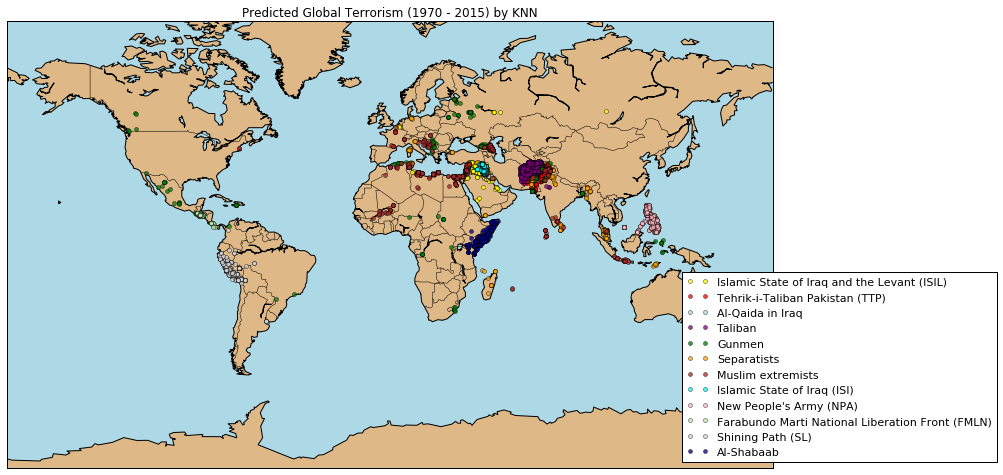

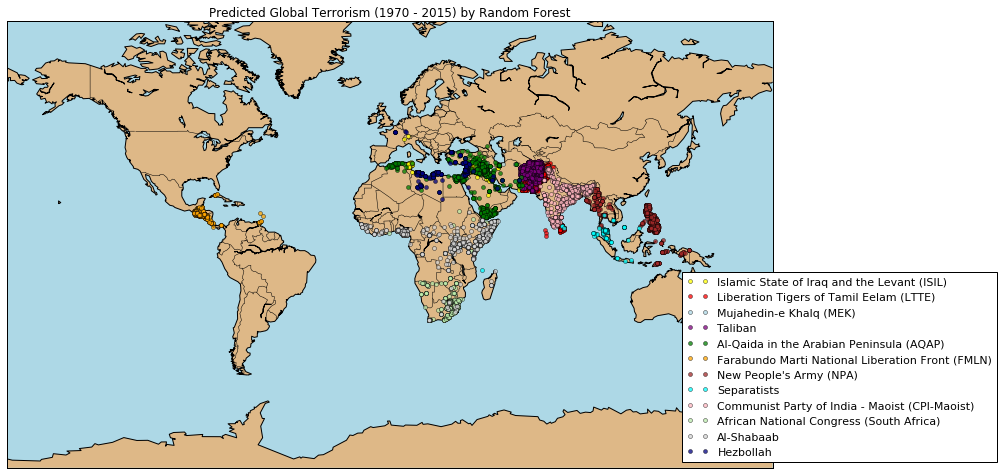

In [19]:
plt.figure(figsize=(15,8))
m3 = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

makeworld(m3)

def pltpredpoints(tgroup, m, key, color = None, label = None):
    x, y = m(list(all_output[key].longitude[all_output[key].group == tgroup].astype("float")),\
            (list(all_output[key].latitude[all_output[key].group == tgroup].astype("float"))))
    points = m.plot(x, y, "o", markersize = 4, color = color, label = label, alpha = .75)
    return(points)

# Plot KNN-predicted attacks geographically
for i, tgroup in enumerate(top_knn_groups):
    pltpredpoints(tgroup, m3, 'knn', color = colors[i], label = tgroup)  

plt.title("Predicted Global Terrorism (1970 - 2015) by KNN")
plt.legend(bbox_to_anchor=(1.3, 0.45), prop= {'size':11})
plt.show() 

plt.figure(figsize=(15,8))
m4 = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

makeworld(m3)

# Plot RF-predicted attacks geographically
for i, tgroup in enumerate(top_rf_groups):
    pltpredpoints(tgroup, m4, 'rf', color = colors[i], label = tgroup)  
    
plt.title("Predicted Global Terrorism (1970 - 2015) by Random Forest")
plt.legend(bbox_to_anchor=(1.3, 0.45), prop= {'size':11})
plt.show() 

#### Activity Distribution over Time
Looking at the two models' respective stackplots. We note that they agree on a few points:
-  **The surge in activity by ISIL over the past decade:** Both models predicted a surge in ISIL attacks since 2010
-  **Surge in FMLN activities in the 1980s:** Again, both models captured a surgein FMLN attacks in the 1980s
-  **Taliban general increase in activity from the 2000s-now:** Both models showed a widening Taliben band as we move towards past the 2000s

On the other hand, while the KNN model predicts a surge in activity from Al Qaida in Iraqand Tehrik-i-Taliban Pakistan from the 2000s-now, the Random Forest model attributes that surge to Liberation Tigers of Tamil Eelam(LTTE) and Mujahedin-e Khalq (MEK).

It appears the models disagree on the set of the 12 most active groups since data became available, with KNN emphasizing generic groups more (Musim extremists, separatists), and Random Forest focusing more on specific groups (LTTE, MEK). Given the trend of known data, where the 12 most active groups were specific groups, one might be inclined to prefer Random Forest in this scenario, as it brings out more insight on specific, active groups.

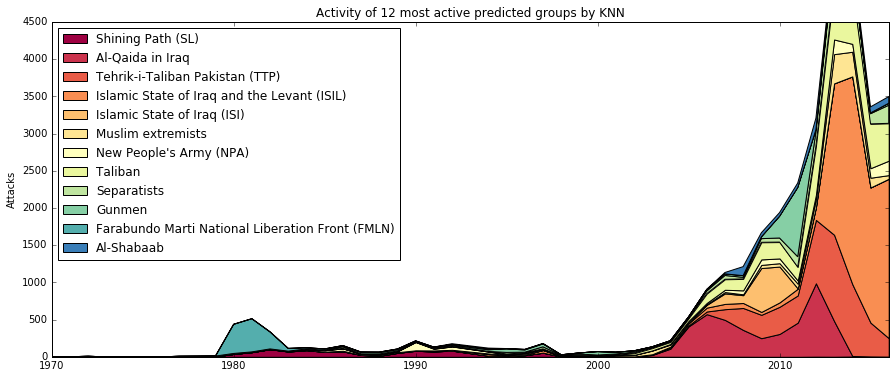

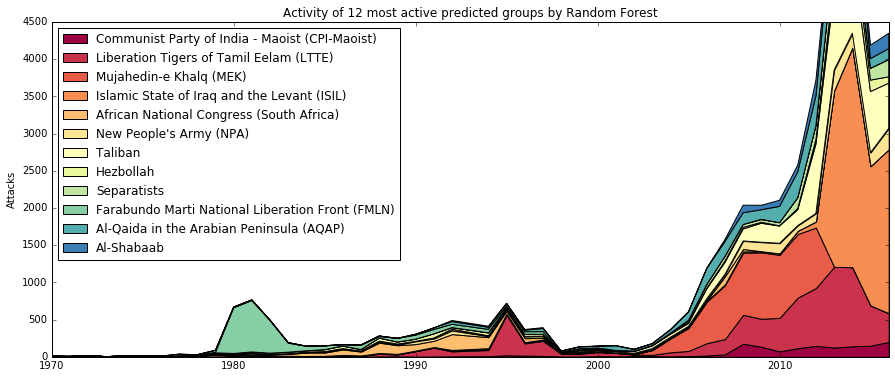

In [23]:
x,ystack,ykeys,cm,NUM_COLORS = datastack(top_knn_groups, all_output['knn'])

# Stackplot against time for KNN
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)

plotstack(x, ystack, ykeys, cm, ax1, NUM_COLORS, 'Activity of 12 most active predicted groups by KNN')

x,ystack,ykeys,cm,NUM_COLORS = datastack(top_rf_groups, all_output['rf'])

# Stackplot against time for RF
fig = plt.figure(figsize=(15,6))
ax2 = fig.add_subplot(111)

plotstack(x, ystack, ykeys, cm, ax2, NUM_COLORS, 'Activity of 12 most active predicted groups by Random Forest')

### Recap and Caveats
This was a quick attempt at creating models to predict unattributed terrorist attacks. As such, there are several caveats present. Below are some a few:
-  **Data Collection:** With the data readily available in the database, such as country, year, and city, we could have introduced further features such as national/city popoulation, GDP, countries with which the country was at war at the time, etc. to see if these additional features can improve the model
-  **Feature Engineering:** We took a few feature engineering measures to help train our model:
    -  __Introducing dummy variables for categorical data__: Much of the data was categorical, which created a lot of new dummy variables for country, attack type, target type, and weapon type. This greatly increased the number of features to train on, and in practice limited the feasibility of certain models and optimization attempts (on the device used for this project)
    -  __Attempting to weight features__: Some limited attempts were made to manually weight features, by leveraging domain knowledge and conclusions drawn from the data exploration. However the models that were ultimately used, KNN and Random Forest, are not significantly affected by these features. With more computing resources, we could have tried probabilistic models such as Gaussian Naive Bayes, and conduct feature weight optimization on that
    -  __Using regional centroidto resolve NaN coordinates__: For any given set of data, whether training, testing, or unlabeled, we had attacks where the coordinates were NaN. In the training and testing data, we used the centroid of that data set to substitute for NaN. For the unlabeled data, we used the centroid of the training data for that region. This could be improved, as often times these attacks had known countries. We could reduce the impact of this bug by using the centroid of the attack's country instead when the coordinates are NaN. As a side onte, we also used 0 as the subtitue value for when fatalities and injuries were NaN.
-  **Defining Inactive Regions:** One condition we did not impose on any of our models is defining strict activity boundaries for terrorist groups. For example, the New People's Army is only active in the Philippines. Thus whatever model we train, it should not predict New People's Army as a label for an input not located in the Philippines. We clearly saw our final Random Forest model fail to consider this, when it predicted some attacks in Thailand/Myanmar/Laos to be caused by New People's Army. The same can be said of Al-Shabaab which is known only to be active in Somalia and Yemen, but our Random Forest model attributed many attacks across central Africa to them.
-  **Accommodating Unlabeled Data:** Specifically when predicting for unlabeled data, we ran into another issue where the features of the data after dummy variables are introduced did not exactly match the features of the training set our optimized classifiers trained on. What we ended up doing was a sort of "outer join" for each region's labeled training data and unlabeled data, where columns that were in one but not the other were added with entries of all zero. Then, we retrained the previously optimized classifiers on the new labeled training data (with added zero columns from the unlabeled data). As the new feature columns had all zeros, this should not have impacted our results greatly, if at all. But it is still worth pointing out.

#### Improving Problem Scoping
From a practical manner, we could have also made this model more useful by considering the scope of objective:
-  **Focusing on high-risk regions:** We noted during the project that some regions such as Central Asia had very few attacks, which made all models perform poorly. In practice, we would probably place more importance on the model performing well in more attack-prone areas. So in setting up this problem, perhaps we could have omitted certain low-attack regions or countries from the onset
-  **Focusing on active terrorist groups:** Not all terrorist groups are equally active at the same time, as we saw. In practice, we are likely more concerned with recently active groups. This means that we could have focused our evaluation of model performance within the scope of the most active 10-50 groups. We could also have focused on our evaluation within the scope of the most active groups of the past 20 years.
-  **Probabilistic prediction vs. classification:** In this exercise, we tried to train a model to output a single predicted label for each input. In practice, for the sake of speed and efficiency, perhaps the audience would be willing to accept a top-3 most likely predicted labels, if it means that more outputs will have the correct label among the top-3. In essence, rather than predict a single group responsible for an attack, give a shortlist of the 3 most likely groups, so that an audience can use that information to focus their efforts. In such a scenario, we would evaluate model performance by its Mean Average Precision @3 score.